# Look at the pH of the system

In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
desktop_root_path = "/home/neil/"
pi_root_path = "/home/pi/"
if os.path.isdir(desktop_root_path):
    data_path = os.path.join(desktop_root_path,"growControl_Data")
    analysis_path = os.path.join(desktop_root_path,"growControl","Analysis")
elif os.path.isdir(pi_root_path):
    data_path = os.path.join(pi_path,"growControl_Data")
    analysis_path = os.path.join(pi_path,"growControl","Analysis")
else:
    raise FileNotFoundError("No valid path to the data was found!")

In [3]:
data_files = {}
for d in os.listdir(data_path):
    if not os.path.isfile(os.path.join(data_path,d)):
        continue
    root = d[:d.rfind("_")]
    full_path = os.path.join(data_path,d)
    if root not in data_files:
        data_files[root] = [full_path]
    else:
        data_files[root].append(full_path)

for key in data_files:
    print(key)
    print("\t{}".format(data_files[key][0]))
    print("\t{}".format(data_files[key][-1]))
    #for file in data_files[key]:
    #    print("\t{}".format(file))

controller_ph_pump
	/home/neil/growControl_Data/controller_ph_pump_2020-02-16.csv
	/home/neil/growControl_Data/controller_ph_pump_2020-02-23.csv
sensor_ph_bin1
	/home/neil/growControl_Data/sensor_ph_bin1_2020-04-12.csv
	/home/neil/growControl_Data/sensor_ph_bin1_2020-04-21.csv
humidity_temp_grow
	/home/neil/growControl_Data/humidity_temp_grow_2020-05-17.csv
	/home/neil/growControl_Data/humidity_temp_grow_2020-04-12.csv
humidity_temp_ambient
	/home/neil/growControl_Data/humidity_temp_ambient_2020-04-11.csv
	/home/neil/growControl_Data/humidity_temp_ambient_2020-05-03.csv
sensor_ph_calibration_raw
	/home/neil/growControl_Data/sensor_ph_calibration_raw_2020-03-22T17:27:02.453885.json
	/home/neil/growControl_Data/sensor_ph_calibration_raw_2020-03-30T06:03:25.392198.json
sensor_volume
	/home/neil/growControl_Data/sensor_volume_2020-05-25.csv
	/home/neil/growControl_Data/sensor_volume_2020-05-25.csv
growControl_Data_oldformat
	/home/neil/growControl_Data/growControl_Data_oldformat_pre2020032

In [4]:
def load_df(root_name):
    li = []
    for fname in sorted(data_files[root_name])[-20:]:
        df_temp = pd.read_csv(fname,index_col=None,header=0,skiprows=lambda x: (x!=0) and not x%10)
        li.append(df_temp)
    df = pd.concat(li,axis=0,ignore_index=True)
    
    for column in df.columns:
        df = df[df[column] != "None"]
        if column != "datetime_timezone":
            df[column] = df[column].astype(float)
        
    df["datetime_timezone"] = pd.to_datetime(df["datetime_timezone"])
    df.sort_values("datetime_timezone",inplace=True)
    df.reset_index(inplace=True,drop=True)
    return df

/home/neil/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/home/neil/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


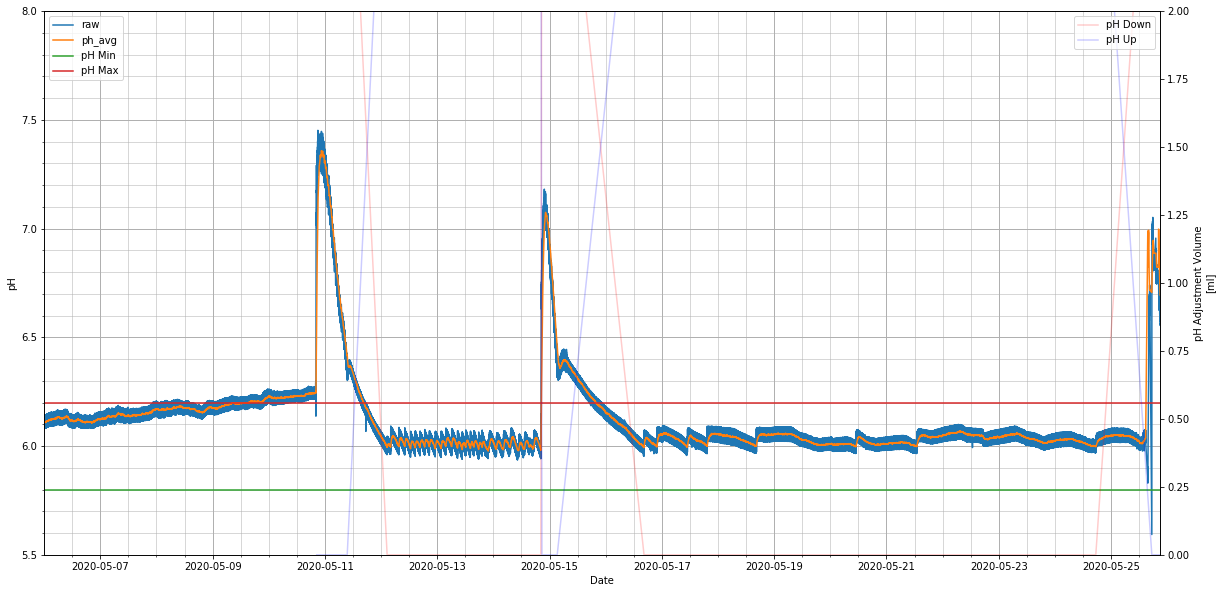

In [5]:
df_ph = load_df("sensor_ph_bin1")
df_control_ph = load_df("controller_ph_pump")

#plt.rcParams["figure.figsize"] = (50,25)
plt.rcParams["figure.figsize"] = (20,10)
fig, ax1 = plt.subplots()
ax1.set_xlabel("Date")
ax1.set_ylabel("pH")

ax1.plot(df_ph["datetime_timezone"],df_ph["ph_raw"],label="raw")
ax1.plot(df_ph["datetime_timezone"],df_ph["ph_avg"],label="ph_avg")

#ax1.plot(df_ph["datetime"],df_ph["ph_avg_ewm_.1"],label="average_factor=0.9 => Current Value")
#ax1.plot(df_ph["datetime"],df_ph["ph_avg_ewm_.01"],label="average_factor=0.99 => Changing To")
#ax1.plot(df_ph["datetime"],df_ph["ph_avg_ewm_.001"],label="average_factor=0.999")

datetime_minmax = [df_ph["datetime_timezone"].min(),df_ph["datetime_timezone"].max()]
ax1.plot(datetime_minmax,[5.8,5.8],label="pH Min")
ax1.plot(datetime_minmax,[6.2,6.2],label="pH Max")

ax1.legend(loc="upper left")
ax1.minorticks_on()
ax1.grid(True,which="major",linewidth=1)
ax1.grid(True,which="minor",linewidth=.5)
plt.ylim((5.5,8.))
plt.xlim(datetime_minmax)

ax2 = ax1.twinx()
ax2.set_ylabel("pH Adjustment Volume\n[ml]")
ax2.plot(df_control_ph["datetime_timezone"],df_control_ph["ph_down_volume"],'r',alpha=.2,label="pH Down")
ax2.plot(df_control_ph["datetime_timezone"],df_control_ph["ph_up_volume"],'b',alpha=.2,label="pH Up")
ax2.legend(loc="upper right")
plt.ylim((0,2.0))
plt.xlim(datetime_minmax)
plt.savefig(os.path.join(analysis_path,"ph_data_{}.png".format(datetime.datetime.now().strftime("%Y%m%dT%H%M%S"))))
plt.show()

In [6]:
def plotData(dataFrames,listOfColumnsInDataFrames):
    
    
    plt.rcParams["figure.figsize"] = (20,10)
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("Date")
    
    y_lim = None
    
    for df,columns in zip(dataFrames,listOfColumnsInDataFrames):
        ax1.set_ylabel(columns)
        for column in columns:
            ax1.plot(df["datetime_timezone"],df[column],label=column)
            if y_lim is None:
                y_lim = [df[column].min(),df[column].max()]
            else:
                y_lim[0] = min(y_lim[0],df[column].min())
                y_lim[1] = min(y_lim[1],df[column].max())
    
    datetime_minmax = [df_ph["datetime_timezone"].min(),df_ph["datetime_timezone"].max()]
    plt.xlim(datetime_minmax)
    
    delta = y_lim[1]-y_lim[0]
    y_lim = [y_lim[0]-.1*delta,y_lim[1]+.1*delta]
    plt.ylim(y_lim)
    
    ax1.minorticks_on()
    ax1.grid(True,which="major",linewidth=1)
    ax1.grid(True,which="minor",linewidth=.5)
    
    
    ax1.legend(loc="upper right")
    plt.show()

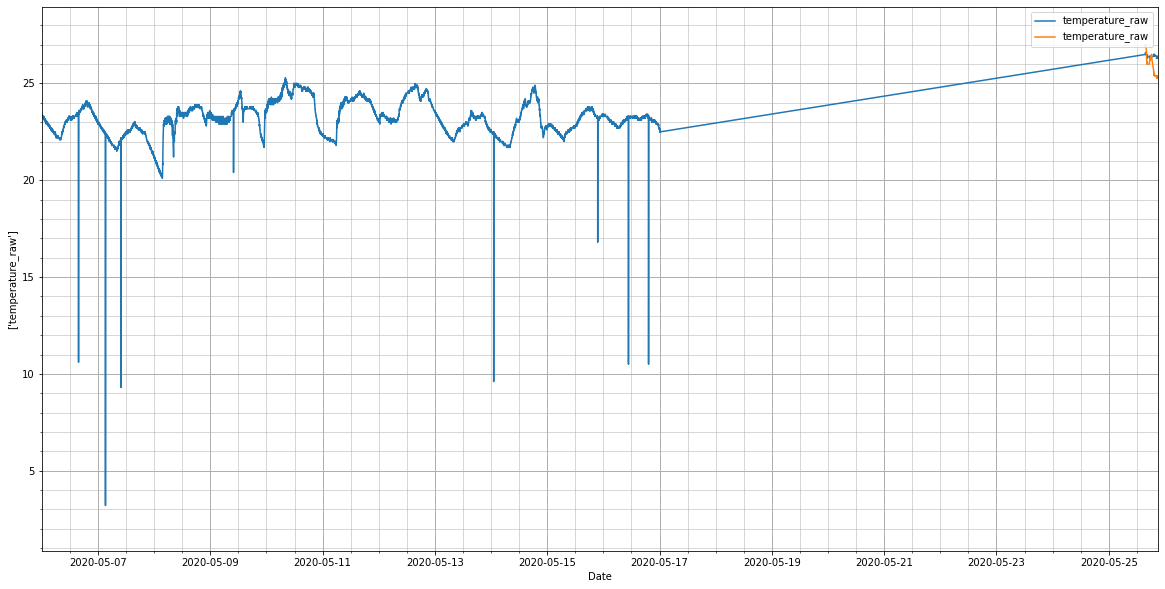

In [7]:
humidity_temp_ambient = load_df("humidity_temp_ambient")
humidity_temp_grow = load_df("humidity_temp_grow")

plotData([humidity_temp_ambient,humidity_temp_grow],[["temperature_raw"],["temperature_raw"]])

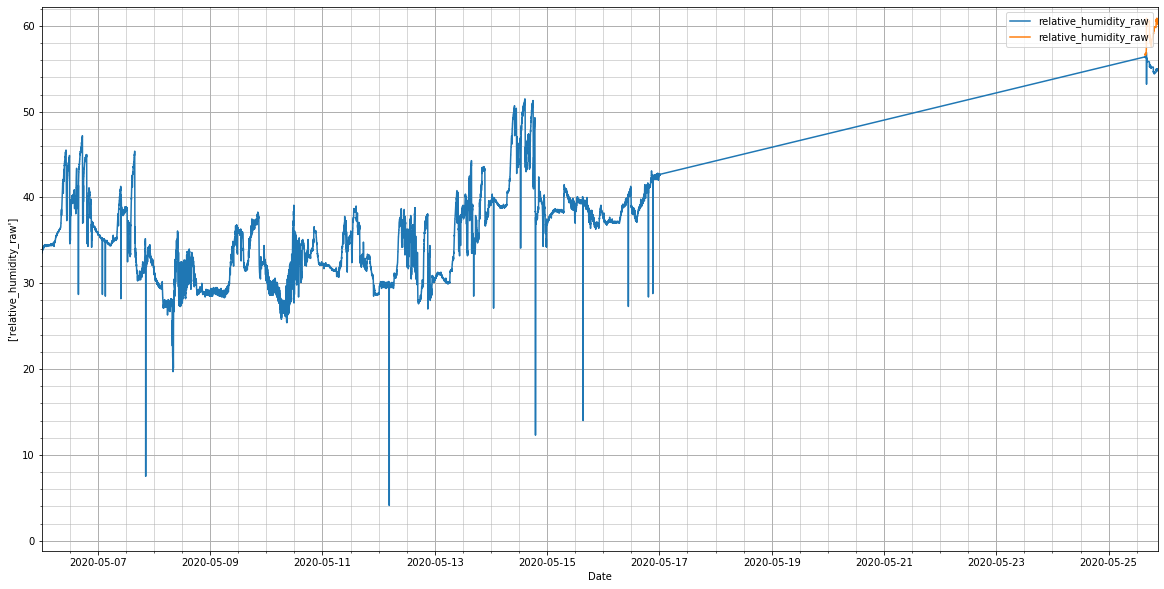

In [8]:
humidity_temp_ambient = load_df("humidity_temp_ambient")
humidity_temp_grow = load_df("humidity_temp_grow")

plotData([humidity_temp_ambient,humidity_temp_grow],[["relative_humidity_raw"],["relative_humidity_raw"]])

In [9]:
print(len(h))
for column in h.columns:
    print(len(h[h[column] != "None"]))

NameError: name 'h' is not defined

In [ ]:
h["temperature_raw"].max()

In [ ]:
h.dtypes

In [ ]:
print(h["temperature_raw"])